In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from juliacall import Main as jl
import copy, pickle, io
from PIL import Image

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [2]:
jl.seval('using SciBmad')

  Activating project at `~/.julia/environments/scibmad`


In [3]:
jl.include("nsrl.jl")
nsrl = jl.nsrl

In [4]:
import helpers

In [5]:
N = 50_000
Z = helpers.sobol_normals(N, 4)
Zx = Z[:, 0:2]
Zy = Z[:, 2:4]

epsilon_a = 7.7e-6
epsilon_b = 7.7e-6

beta_a = 7
beta_b = 8
alpha_a = -0.3
alpha_b = -0.8

Mx = np.array([[np.sqrt(beta_a), 0],
               [-alpha_a / np.sqrt(beta_a), 1/np.sqrt(beta_a)]])
My = np.array([[np.sqrt(beta_b), 0],
               [-alpha_b / np.sqrt(beta_b), 1/np.sqrt(beta_b)]])

coords_x = np.sqrt(epsilon_a) * (Zx @ Mx.T)
coords_y = np.sqrt(epsilon_b) * (Zy @ My.T)
coords_z = np.zeros((N, 2))

coords = np.hstack([coords_x, coords_y, coords_z])

/Users/eiadhamwi/miniforge3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


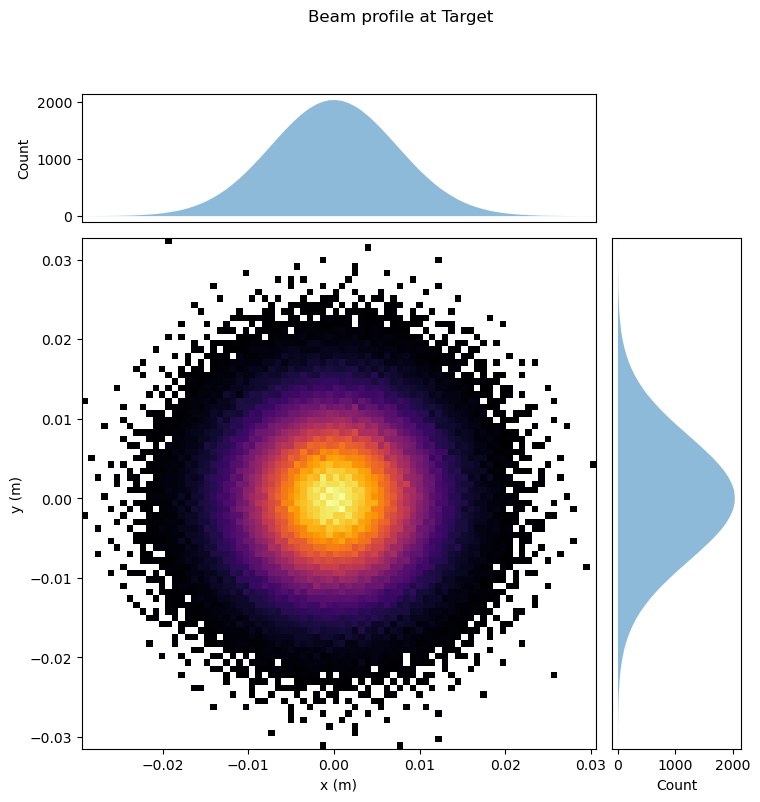

In [6]:
helpers.hist(
    coords, 
    xlims=None, ylims=None,
    nx=80, ny=80, 
);

In [7]:
# Track the bunch through the beamline
bunch = jl.track(nsrl, coords);

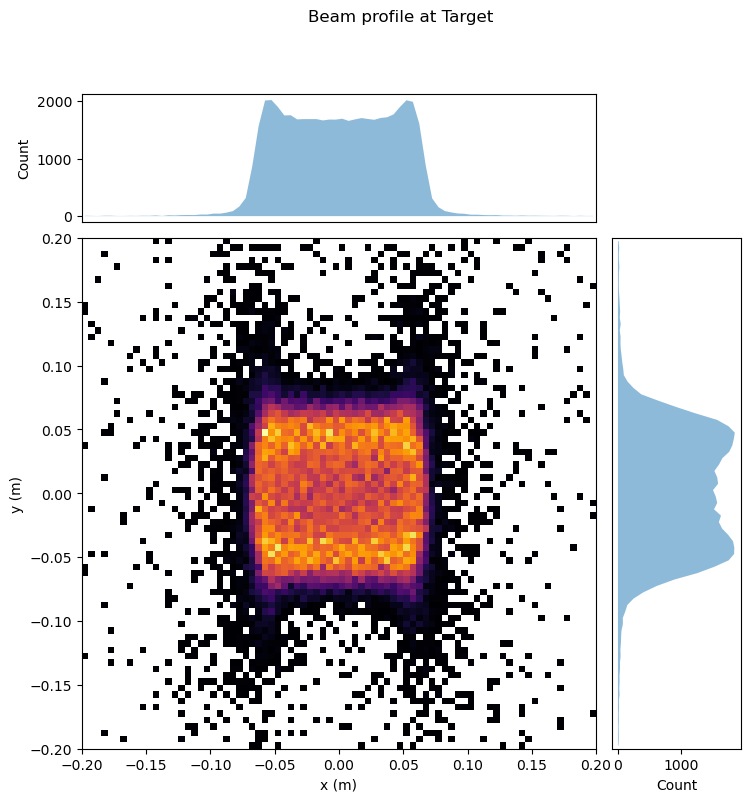

In [8]:
# Visualize tracked bunch
p0 = helpers.hist(
    bunch, 
    xlims=(-0.2,0.2), ylims=(-0.2,0.2),
    nx=80, ny=80
)

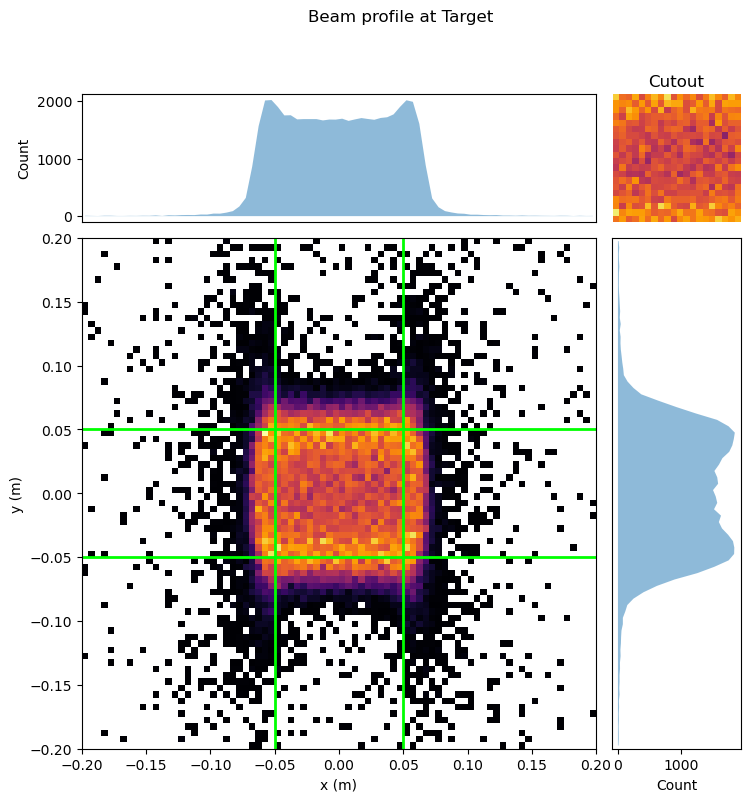

In [9]:
helpers.hist(
    bunch, 
    nx=80, ny=80,
    h=0.05, v=0.05,
    cutout=True
);

In [10]:
cutout = helpers.hist(
    bunch, 
    nx=80, ny=80,
    h=0.05, v=0.05,
    cutout=True,
    make_plot=False
)

In [11]:
cutout_hist = cutout['cutout']
n_particles = cutout['n_total']

print(f"Portion of total: {cutout_hist.sum() / n_particles * 100:.3f} %")
print(f"Mean: {np.mean(cutout_hist):.3f}")
print(f"STD: {np.std(cutout_hist):.3f}")
print(f"Max: {np.max(cutout_hist):.3f}  Min: {np.min(cutout_hist):.3f}")

Portion of total: 47.666 %
Mean: 59.583
STD: 9.245
Max: 89.000  Min: 36.000


In [12]:
def box_merit(cutout):
    box_data, n_total = cutout['cutout'], cutout['n_total']

    arr = box_data.flatten()
    arr = arr[~np.isnan(arr)]
    frac = arr.sum() / n_total
    uniformity = np.std(arr) / np.mean(arr) if arr.size > 0 else np.nan
    return frac, uniformity

In [13]:
box_merit(cutout)

(np.float64(0.47666), np.float64(0.1551658855340292))

In [14]:
# Get references to Julia objects
Q3 = jl.Q3
Q4 = jl.Q4
O1 = jl.O1
O2 = jl.O2

In [17]:
import math
from xopt import Xopt
from xopt.vocs import VOCS
from xopt.evaluator import Evaluator
from xopt.generators.bayesian import ExpectedImprovementGenerator

In [18]:
vocs = VOCS(
    variables={
        "x1": [ 2.0,  4.0], 
        "x2": [-4.0, -2.0], 
        "x3": [1250., 2250.]
    },
    objectives={"f": "MINIMIZE"},
)

def merit_function(x):
    Q3.Bn1 =  x["x1"]
    Q4.Bn1 =  x["x2"]
    O1.Bn3 = -x["x3"]
    O2.Bn3 =  x["x3"]
    
    # Track bunch
    coords_tmp = jl.track(nsrl, coords)
    
    # Compute objectives
    cutout_tmp = helpers.hist(coords_tmp, h=0.07, v=0.07, cutout=True, make_plot=False)
    frac, uniform = box_merit(cutout_tmp)
    
    # Merit function: minimize uniformity and penalize low fraction
    cost = uniform + np.exp(25 * (0.70 - frac))

    return {"f": cost}

In [19]:
evaluator = Evaluator(function=merit_function)

generator = ExpectedImprovementGenerator(vocs=vocs, turbo_controller="optimize")
generator.gp_constructor.use_low_noise_prior = True

X = Xopt(evaluator=evaluator, generator=generator, vocs=vocs)

_tmp = {
    "x1" :  [3.0, 2.0, 2.0, 4.0, 4.0],
    "x2" : [-3.0, -4.0, -2.0, -2.0, -4.0],
    "x3" : [1.75e3, 1.75e3, 1.75e3, 1.75e3, 1.75e3]
}

X.evaluate_data(_tmp)

,x1,x2,x3,f,xopt_runtime,xopt_error
0,3.0,-3.0,1750.0,0.261510,0.187615,False
1,2.0,-4.0,1750.0,82455.056353,0.211288,False
2,2.0,-2.0,1750.0,5.127069,0.133537,False
3,4.0,-2.0,1750.0,15.131757,0.139562,False
4,4.0,-4.0,1750.0,13.038510,0.138148,False


In [20]:
start_time = time.time()
for i in range(100):
    X.step()
    if i%10 == 0:
        print(f"{i:d} steps complete: {time.time() - start_time:.1f} seconds")
elapsed = time.time() - start_time
print(f"Bayesian optimization complete! Elapsed time: {elapsed:.1f} seconds")

0 steps complete: 0.9 seconds
10 steps complete: 6.8 seconds
20 steps complete: 12.3 seconds
30 steps complete: 18.2 seconds
40 steps complete: 22.4 seconds
50 steps complete: 27.7 seconds
60 steps complete: 33.2 seconds
70 steps complete: 38.8 seconds
80 steps complete: 46.7 seconds
90 steps complete: 55.1 seconds
Bayesian optimization complete! Elapsed time: 58.2 seconds


In [63]:
X.data

,x1,x2,x3,f,xopt_runtime,xopt_error
0,3.000000,-3.000000,1750.000000,0.261510,0.114088,False
1,2.000000,-4.000000,1750.000000,82455.056353,0.114475,False
2,2.000000,-2.000000,1750.000000,5.127069,0.111527,False
3,4.000000,-2.000000,1750.000000,15.131757,0.110380,False
4,4.000000,-4.000000,1750.000000,13.038510,0.115473,False
...,...,...,...,...,...,...
100,2.983160,-2.714280,1508.081691,0.376758,0.124769,False
101,2.964400,-2.945455,1486.009927,0.198188,0.137005,False
102,2.953796,-2.921399,1474.639464,0.202391,0.129185,False
103,2.839424,-2.955048,1322.591414,0.362826,0.128617,False


In [21]:
best_ind = np.where(X.data["f"] == X.data["f"].min())[0]
best_f = X.data.loc[best_ind]
best_f

,x1,x2,x3,f,xopt_runtime,xopt_error
84,3.036899,-2.97769,1697.715066,0.240266,0.134957,False


In [226]:
X.evaluate_data({
    "x1":2.96481,
    "x2":-2.950054,
    "x3":1466.837819
})

,x1,x2,x3,f,xopt_runtime,xopt_error
0,2.96481,-2.950054,1466.837819,0.199743,0.171005,False



Applying optimized parameters:
Q3.Bn1 = 3.036899
Q4.Bn1 = -2.977690
O1.Bn3 = -1697.715066
O2.Bn3 = 1697.715066

Optimized merit:
Fraction in box: 0.5025
Uniformity (STD/Mean): 0.1495


Text(0.5, 0, 'Count')

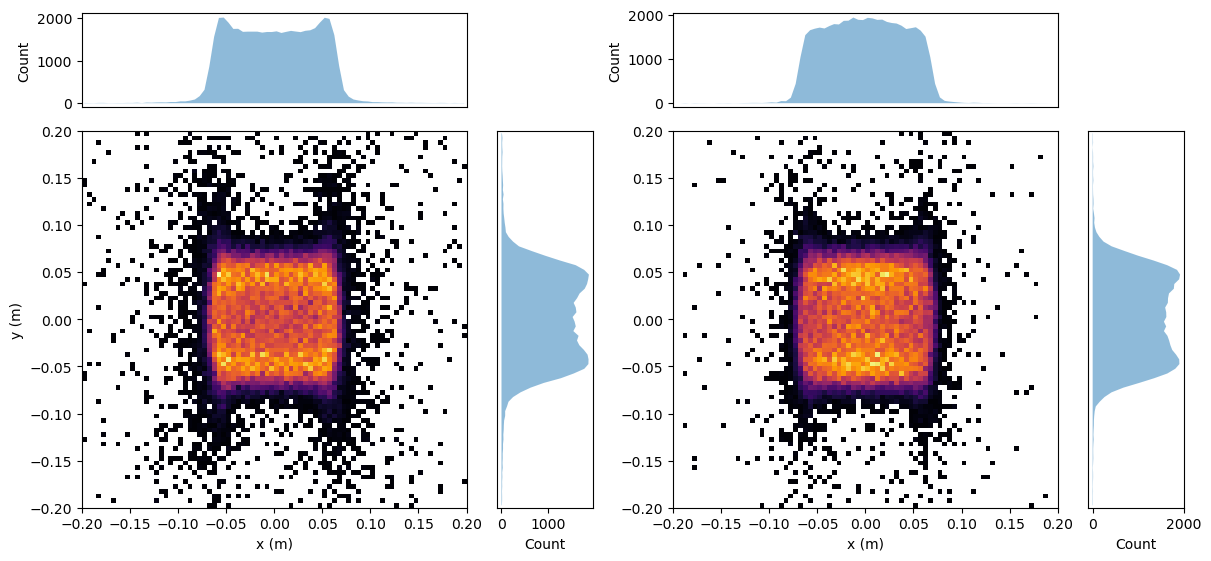

In [22]:
# Apply optimized parameters and visualize results
Q3.Bn1 = best_f["x1"].iloc[0]
Q4.Bn1 = best_f["x2"].iloc[0]
O1.Bn3 =-best_f["x3"].iloc[0]
O2.Bn3 = best_f["x3"].iloc[0]

print(f"\nApplying optimized parameters:")
print(f"Q3.Bn1 = {Q3.Bn1:.6f}")
print(f"Q4.Bn1 = {Q4.Bn1:.6f}")
print(f"O1.Bn3 = {O1.Bn3:.6f}")
print(f"O2.Bn3 = {O2.Bn3:.6f}")

# Track with optimized parameters
b_opt = jl.track(nsrl, coords)

# Compute merit
cutout_tmp = helpers.hist(b_opt, nx=80, ny=80, make_plot=False, cutout=True)
frac_opt, uniform_opt = box_merit(cutout_tmp)
print(f"\nOptimized merit:")
print(f"Fraction in box: {frac_opt:.4f}")
print(f"Uniformity (STD/Mean): {uniform_opt:.4f}")

# 1) Reuse your function's "data-only" path
A = helpers.hist(bunch, make_plot=False)
B = helpers.hist(b_opt, make_plot=False)

# 2) Centers + marginals (from the returned arrays)
x_edges, y_edges = A["x_edges"], A["y_edges"]  # same for B by construction
x_cent = 0.5 * (x_edges[:-1] + x_edges[1:])
y_cent = 0.5 * (y_edges[:-1] + y_edges[1:])

Ax_marg = np.nansum(A["hist"], axis=1)  # sum over y (rows)
Ay_marg = np.nansum(A["hist"], axis=0)  # sum over x (cols)
Bx_marg = np.nansum(B["hist"], axis=1)
By_marg = np.nansum(B["hist"], axis=0)

# 3) Shared color scale
vmin, vmax = 0.0, np.nanmax([np.nanmax(A["hist"]), np.nanmax(B["hist"])])

# 4) Layout: 2 rows × 4 cols → [A_main|A_right|B_main|B_right] with top marginals above mains
fig = plt.figure(figsize=(12, 5.5), constrained_layout=True)
gs  = fig.add_gridspec(2, 4,
                       width_ratios=[0.8, 0.2, 0.8, 0.2],
                       height_ratios=[0.2, 0.8],
                       wspace=0.05, hspace=0.05)

# --- A ---
axA_top   = fig.add_subplot(gs[0,0])
axA_main  = fig.add_subplot(gs[1,0])
axA_right = fig.add_subplot(gs[1,1])

axA_top.fill_between(x_cent, Ax_marg, alpha=0.5)
axA_top.set_xlim((-0.2,0.2)); axA_top.set_xticks([]); axA_top.set_ylabel("Count")

mA = axA_main.pcolormesh(x_edges, y_edges, A["hist"].T, shading="auto",
                         cmap="inferno", vmin=vmin, vmax=vmax)
axA_main.set_xlabel("x (m)"); axA_main.set_ylabel("y (m)")
axA_main.set_aspect('auto')

axA_right.fill_betweenx(y_cent, Ay_marg, alpha=0.5)
axA_right.set_ylim((-0.2,0.2)); axA_right.set_yticks([]); axA_right.set_xlabel("Count")
axA_main.tick_params(labelleft=True, labelbottom=True)


# --- B (share x/y with A for perfect alignment) ---
axB_top   = fig.add_subplot(gs[0,2])
axB_main  = fig.add_subplot(gs[1,2])
axB_right = fig.add_subplot(gs[1,3])


axB_top.fill_between(x_cent, Bx_marg, alpha=0.5)
axB_top.set_xlim((-0.2,0.2)); axB_top.set_xticks([]); axB_top.set_ylabel("Count")

mB = axB_main.pcolormesh(x_edges, y_edges, B["hist"].T, shading="auto",
                         cmap="inferno", vmin=vmin, vmax=vmax)
axB_main.set_xlabel("x (m)")
axB_main.set_aspect('auto')
axB_main.tick_params(labelleft=True, labelbottom=True)

axB_right.fill_betweenx(y_cent, By_marg, alpha=0.5)
axB_right.set_ylim((-0.2,0.2)); axB_right.set_yticks([]); axB_right.set_xlabel("Count")

In [15]:
# Parameter scan: vary box size
# Scan different Q3, Q4 settings and box sizes to optimize beam uniformity
import time

# Initialize result array
merit_size = np.zeros((21, 21, 3, 2))

print("Starting parameter scan over box sizes...")
start_time = time.time()

for i, q3_b1 in enumerate(np.arange(2, 4.1, 0.1)):
    
    Q3.Bn1 = q3_b1
    
    for j, q4_b1 in enumerate(np.arange(-2, -4.1, -0.1)):
        
        Q4.Bn1 = q4_b1
        
        try:
            coords_tmp = jl.track(nsrl, coords)
    
            for k, size in enumerate(np.arange(0.05, 0.08, 0.01)):
                
                cutout_tmp = helpers.hist(
                    coords_tmp, 
                    h=size, v=size, 
                    cutout=True, 
                    make_plot=False
                )
                merit_size[i, j, k, :] = box_merit(cutout_tmp)
                
        except Exception as e:
            merit_size[i, j, k, :] = np.nan
            
    if i % 5 == 0:
        print(f"Progress: {i+1}/21 Q3 values completed")

elapsed = time.time() - start_time
print(f"Scan complete! Elapsed time: {elapsed:.1f} seconds")

Starting parameter scan over box sizes...
Progress: 1/21 Q3 values completed
Progress: 6/21 Q3 values completed
Progress: 11/21 Q3 values completed
Progress: 16/21 Q3 values completed
Progress: 21/21 Q3 values completed
Scan complete! Elapsed time: 63.8 seconds


/var/folders/fk/b4j2dkwn5090v4msn0vr3q3h0000gn/T/ipykernel_83941/3354495627.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


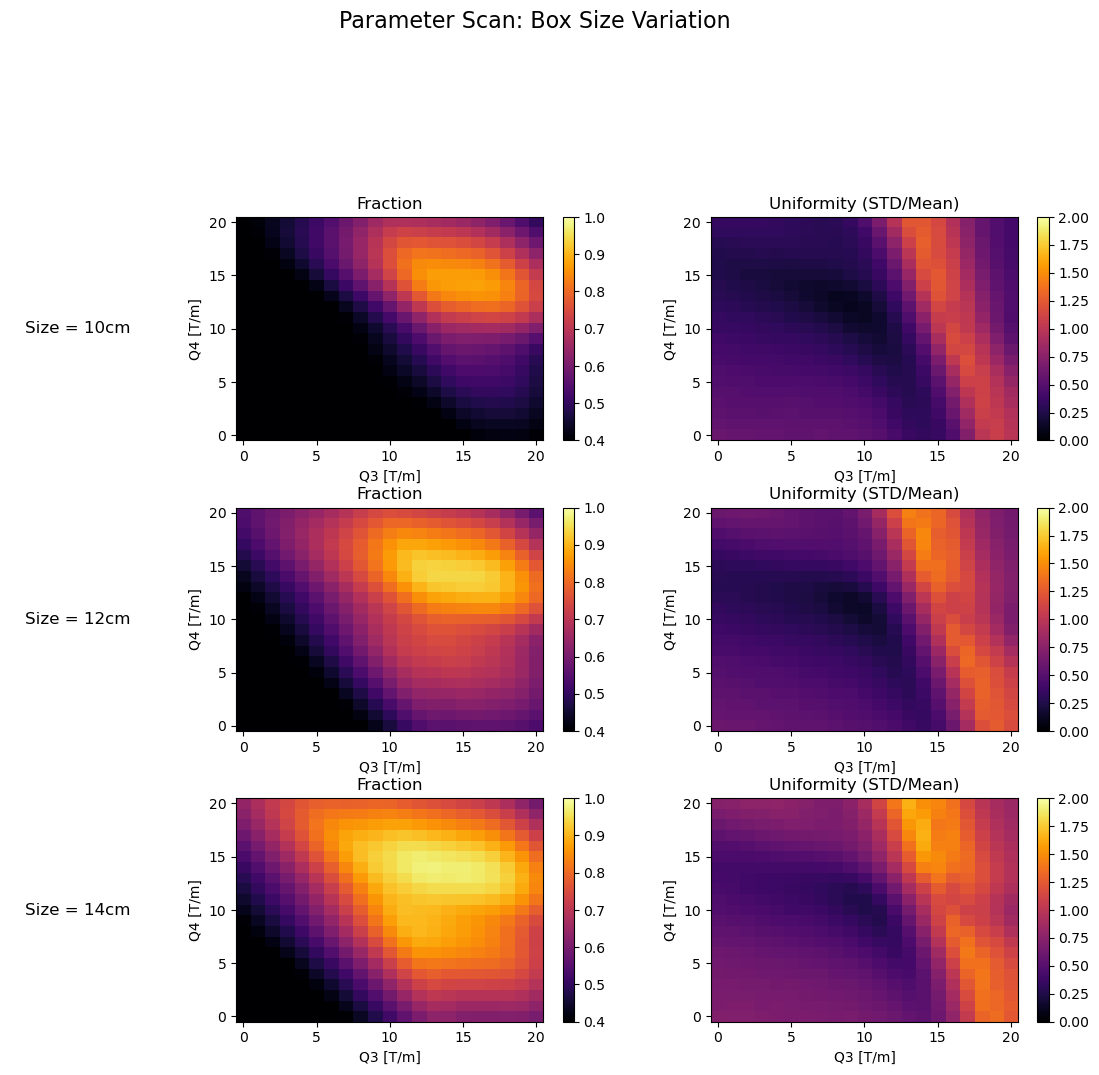

In [16]:
# Visualize results: create heatmaps for all 3 box sizes
fig = plt.figure(figsize=(14, 18))
gs = GridSpec(5, 3, figure=fig, width_ratios=[0.15, 0.425, 0.425], 
              wspace=0.3, hspace=0.3)

q3_vals = np.arange(2, 4.1, 0.1)
q4_vals = np.arange(-4, -1.9, 0.1)  # Reversed for display

for k in range(3):
    size_cm = 5 + k  # 5cm to 9cm
    
    # Text annotation
    ax_text = fig.add_subplot(gs[k, 0])
    ax_text.text(0.5, 0.5, f'Size = {2*size_cm}cm', 
                ha='center', va='center', fontsize=12)
    ax_text.axis('off')
    
    # Fraction heatmap
    ax_frac = fig.add_subplot(gs[k, 1])
    data_frac = merit_size[:, ::-1, k, 0].T
    im1 = ax_frac.imshow(data_frac, aspect='auto', origin='lower',
                         vmin=0.4, vmax=1.0, cmap='inferno')
    ax_frac.set_xlabel('Q3 [T/m]')
    ax_frac.set_ylabel('Q4 [T/m]')
    ax_frac.set_title('Fraction')
    plt.colorbar(im1, ax=ax_frac)
    
    # Uniformity heatmap
    ax_unif = fig.add_subplot(gs[k, 2])
    data_unif = merit_size[:, ::-1, k, 1].T
    im2 = ax_unif.imshow(data_unif, aspect='auto', origin='lower',
                         vmin=0.0, vmax=2.0, cmap='inferno')
    ax_unif.set_xlabel('Q3 [T/m]')
    ax_unif.set_ylabel('Q4 [T/m]')
    ax_unif.set_title('Uniformity (STD/Mean)')
    plt.colorbar(im2, ax=ax_unif)

plt.suptitle('Parameter Scan: Box Size Variation', fontsize=16, y=0.995)
plt.tight_layout()
plt.show()

In [ ]:
# Parameter scan: vary octupole strength
# Scan Q3, Q4, and octupole settings
merit_oct = np.zeros((21, 21, 5, 2))


print("Starting octupole parameter scan...")
start_time = time.time()

for i, q3_b1 in enumerate(np.arange(2, 4.1, 0.1)):
    Q3.Bn1 = q3_b1
    for j, q4_b1 in enumerate(np.arange(-2, -4.1, -0.1)):
        Q4.Bn1 = q4_b1
        for k, o_b3 in enumerate(np.arange(1250, 2251, 250)):
            O1.Bn3 = -o_b3
            O2.Bn3 = o_b3
            
            try:
                # Track bunch
                coords_tmp = jl.track(nsrl, coords)
                # Compute histogram
                cutout_tmp = hist(
                    coords_tmp, 
                    nx=80, ny=80, 
                    h=0.05, v=0.05, 
                    cutout=True,
                    make_plot=False
                )
                merit_oct[i, j, k, :] = box_merit(cutout_tmp)
                
            except Exception as e:
                merit_oct[i, j, k, :] = np.nan
                
    if i % 5 == 0:
        print(f"Progress: {i+1}/21 Q3 values completed")

elapsed = time.time() - start_time
print(f"Octupole scan complete! Elapsed time: {elapsed:.1f} seconds")

In [ ]:
# Visualize octupole scan results
fig = plt.figure(figsize=(14, 18))
gs = GridSpec(5, 3, figure=fig, width_ratios=[0.15, 0.425, 0.425], 
              wspace=0.3, hspace=0.3)

q3_vals = np.arange(2, 4.1, 0.1)
q4_vals = np.arange(-4, -1.9, 0.1)  # Reversed for display

for k in range(5):
    bn3_val = 1250 + 250 * k
    
    # Text annotation
    ax_text = fig.add_subplot(gs[k, 0])
    ax_text.text(0.5, 0.5, f'Bn3 = {bn3_val}\n[T/m³]', 
                ha='center', va='center', fontsize=12)
    ax_text.axis('off')
    
    # Fraction heatmap
    ax_frac = fig.add_subplot(gs[k, 1])
    data_frac = merit_oct[:, ::-1, k, 0].T
    im1 = ax_frac.imshow(data_frac, aspect='auto', origin='lower',
                        extent=[q3_vals[0], q3_vals[-1], q4_vals[0], q4_vals[-1]],
                        cmap='infero')
    ax_frac.set_xlabel('Q3 [T/m]')
    ax_frac.set_ylabel('Q4 [T/m]')
    ax_frac.set_title('Fraction')
    plt.colorbar(im1, ax=ax_frac)
    
    # Uniformity heatmap
    ax_unif = fig.add_subplot(gs[k, 2])
    data_unif = merit_oct[:, ::-1, k, 1].T
    im2 = ax_unif.imshow(data_unif, aspect='auto', origin='lower',
                        extent=[q3_vals[0], q3_vals[-1], q4_vals[0], q4_vals[-1]],
                        cmap='inferno')
    ax_unif.set_xlabel('Q3 [T/m]')
    ax_unif.set_ylabel('Q4 [T/m]')
    ax_unif.set_title('Uniformity (STD/Mean)')
    plt.colorbar(im2, ax=ax_unif)

plt.suptitle('Parameter Scan: Octupole Strength Variation', fontsize=16, y=0.995)
plt.tight_layout()
plt.show()